In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
end1 = datetime.date(2023, 8, 31)
start1 = datetime.date(2011, 8, 31)
ticker1 = "TSLA"

In [3]:
df = yf.download(ticker1, start=start1, end=end1, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

Downloaded 3019 rows and 6 columns of TSLA data


In [4]:
df1 = df.copy()

In [5]:
df1.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df1.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df1.tail())

             adj_close
Date                  
2023-08-24  230.039993
2023-08-25  238.589996
2023-08-28  238.820007
2023-08-29  257.179993
2023-08-30  256.899994


In [6]:
df1['simple_returns'] = df1['adj_close'].pct_change()
df1['log_returns'] = np.log(df1['adj_close'] / df1['adj_close'].shift(1))

### Visualizing the data

Because time series is sequential, plotting the data allows us to get an intuitive feel for how it fluctuates over time. It also helps us reason about features that could explain the variation we see.

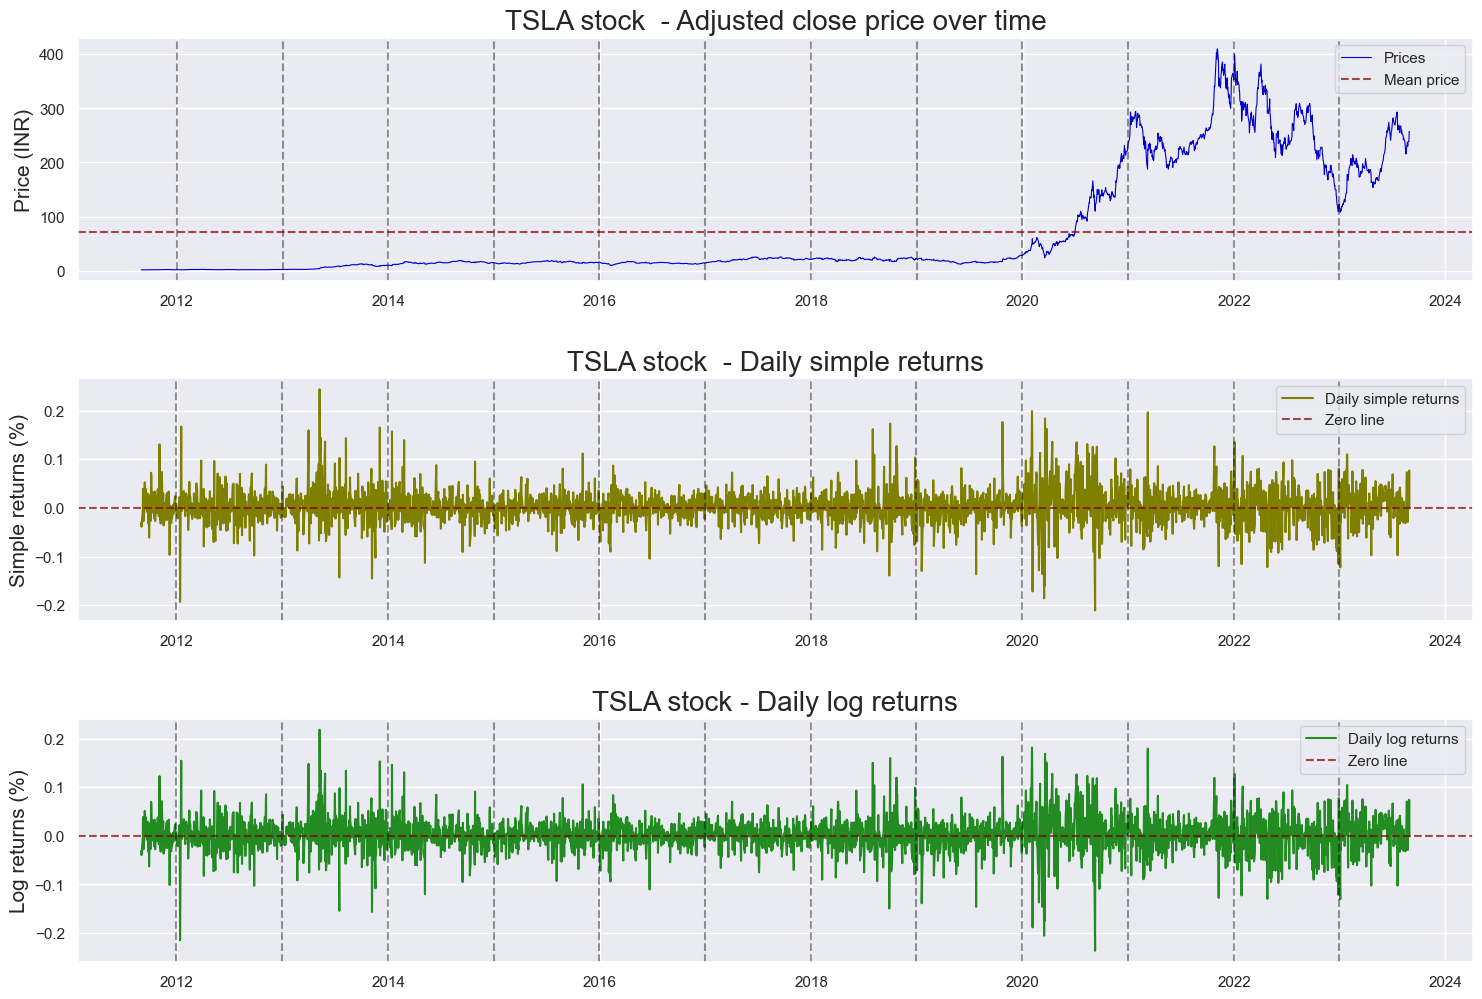

In [7]:
## Plotting the results together
M = 3
N = 1

fig, ax = plt.subplots(M, N, figsize=(18, 12))

ax[0].plot(df1['adj_close'], color='mediumblue', label='Prices', linewidth=0.8)
ax[0].set_title(f"{ticker1} stock  - Adjusted close price over time", fontsize=20)
ax[0].set_ylabel("Price (INR)", fontsize=15)

ax[1].plot(df1['simple_returns'], color='olive', label='Daily simple returns')
ax[1].set_title(f"{ticker1} stock  - Daily simple returns", fontsize=20)
ax[1].set_ylabel("Simple returns (%)", fontsize=15)

ax[2].plot(df1['log_returns'], color='forestgreen', label='Daily log returns')
ax[2].set_title(f"{ticker1} stock - Daily log returns", fontsize=20)
ax[2].set_ylabel("Log returns (%)", fontsize=15)


for i in range(3):
    for eachyear in range(start1.year,end1.year):
        ax[i].axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

ax[0].axhline(df1['adj_close'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
ax[1].axhline(0, color='maroon', label='Zero line', linestyle='--', alpha=0.7)
ax[2].axhline(0, color='maroon', label='Zero line', linestyle='--', alpha=0.7)

# Legend addition
#ax[0].legend(['Prices', 'Mean price'], loc='best')
#ax[1].legend(['Daily simple returns', 'Zero line'], loc='best')
#ax[2].legend(['Daily log returns', 'Zero line'], loc='best')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')


# To set the spacing between subplots
plt.subplots_adjust(hspace=0.4)

### Calculating realized volatility

Realized volatility calculates the magnitude of price movements of an asset over a specified time period. It's a commonly used risk measure.

We will now use the daily data to calculate monthly realized volatility (applying the [Barndorff-Nielsen & Shephard method](#bnshephard)) shown below.

1. Calculate the daily log returns
$$r_t = log (P_t) - log (P_{t-1})$$

2. Calculate the monthly realized variance by summing the squared returns for the `N` trading days of that month.
$$ \sum_{t=1}^N {r_t}^2$$

3. The monthly realized volatility is the square root of the above expression,

4. We annualize the value by multiplying the monthly realized volatility by $\sqrt{12}$.

Let's implement it in Python.

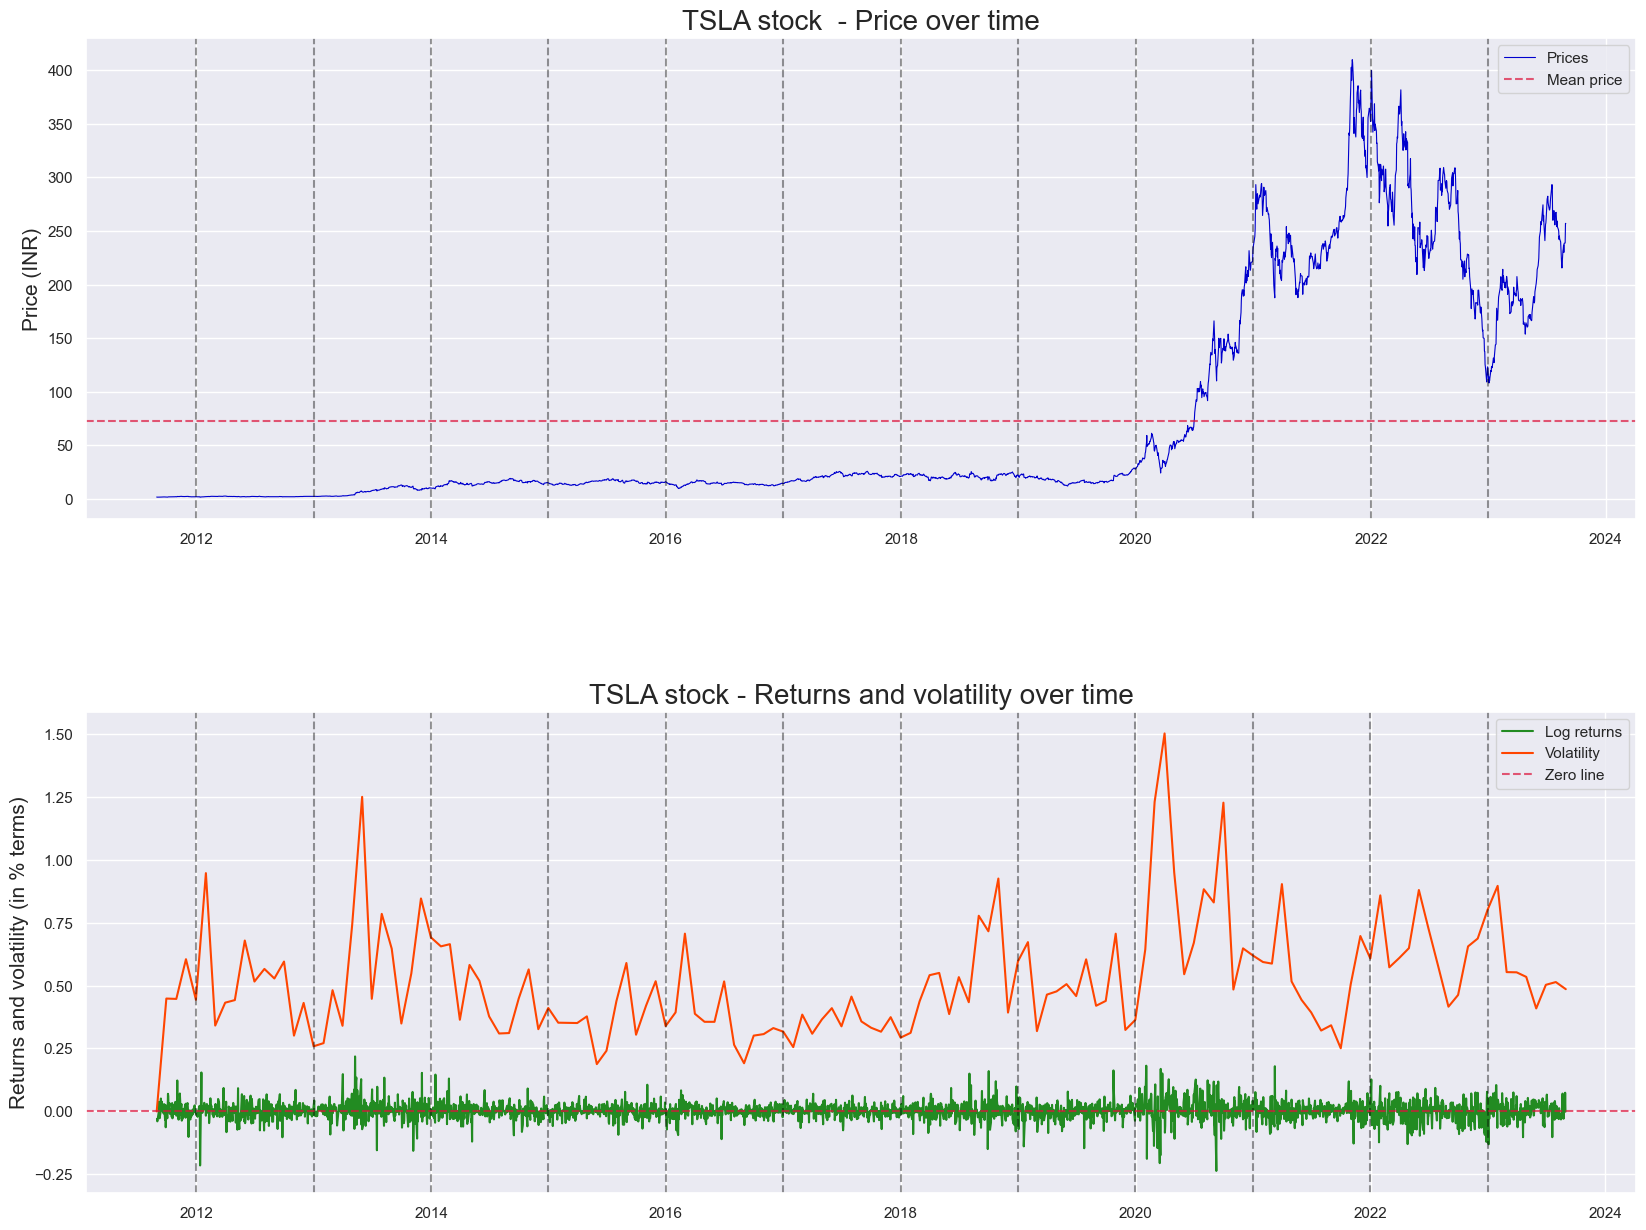

In [8]:
## Defining a function to calculate realized volatility

def realized_vol(x):
    return np.sqrt(np.sum(x ** 2))

## Calculating the monthly realized volatility

df1_real_vol = df1.groupby(pd.Grouper(freq='M'))[['log_returns']].apply(realized_vol)
# .apply would apply the function 'realized_vol' to the column selected (which would be 
# log returns for each month).
# Note that the function calculates the square root of the sum of squared returns for each month

df1_real_vol.rename(columns={'log_returns': 'realized_vol'}, inplace=True)

df1_real_vol.head()

df1_real_vol.tail()

## Calculating the annualized volatility

df1_real_vol['realized_vol'] = df1_real_vol['realized_vol'] * np.sqrt(12)

## Plotting the results together
M = 2
N = 1

fig, ax = plt.subplots(M, N, figsize=(20, 15))

ax[0].plot(df1['adj_close'], color='mediumblue', linewidth=0.8, label='Prices')
ax[0].set_title(f"{ticker1} stock  - Price over time", fontsize=20)
#ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel("Price (INR)", fontsize=15)

ax[1].plot(df1['log_returns'], color='forestgreen', label='Log returns')
ax[1].plot(df1_real_vol['realized_vol'], color='orangered', label='Volatility')
ax[1].set_title(f"{ticker1} stock - Returns and volatility over time", fontsize=20)
ax[1].set_ylabel("Returns and volatility (in % terms)", fontsize=15)



for i in range(2):
    for eachyear in range(start1.year,end1.year):
        ax[i].axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

ax[0].axhline(df1['adj_close'].mean(), label='Mean price', color='crimson', linestyle='--', alpha=0.7)
ax[1].axhline(0, color='crimson', label='Zero line', linestyle='--', alpha=0.7)


# Legend addition
ax[0].legend(loc='best')
ax[1].legend(loc='best')


# To set the spacing between subplots
plt.subplots_adjust(hspace=0.4)

Points to note:
- Extreme price changes are synonymous with large changes in daily returns.
- Large changes in returns often coincide with spikes in volatility
- There are some outliers in returns which can bias our interpretations
- We use the `.resample()` method in `pandas` when we want to change the frequency of our observations (ex. moving from daily returns to weekly returns or monthly returns). However, since realized volatility calculation is a little convoluted, we created the function `realized_vol`.

### Detecting outliers

Compared to many other fields in the social sciences, financial market data for the most part is quite clean (with relatively fewer errors). Nevertheless, it still behooves us to analyze our data and identify any observations that are significantly different from their neighboring observations. We call such data points, **outliers**.

Outliers could be because of:
- Incorrectly entered or calculated in the data source
- Missing data 
- Missing data auto-filled with random values
- A major market event, etc.

Outliers in our data affect both, the analysis we do and the results that follow when building a model or backtesting a strategy. No matter how good our trading strategy looks or how sophisticated our model is, remember: *'garbage in, garbage out'*.

Let's look at one way of catching and marking out the outliers in the `GLENMARK` data. We define outliers as any return value that is more than three standard deviations away from the mean.


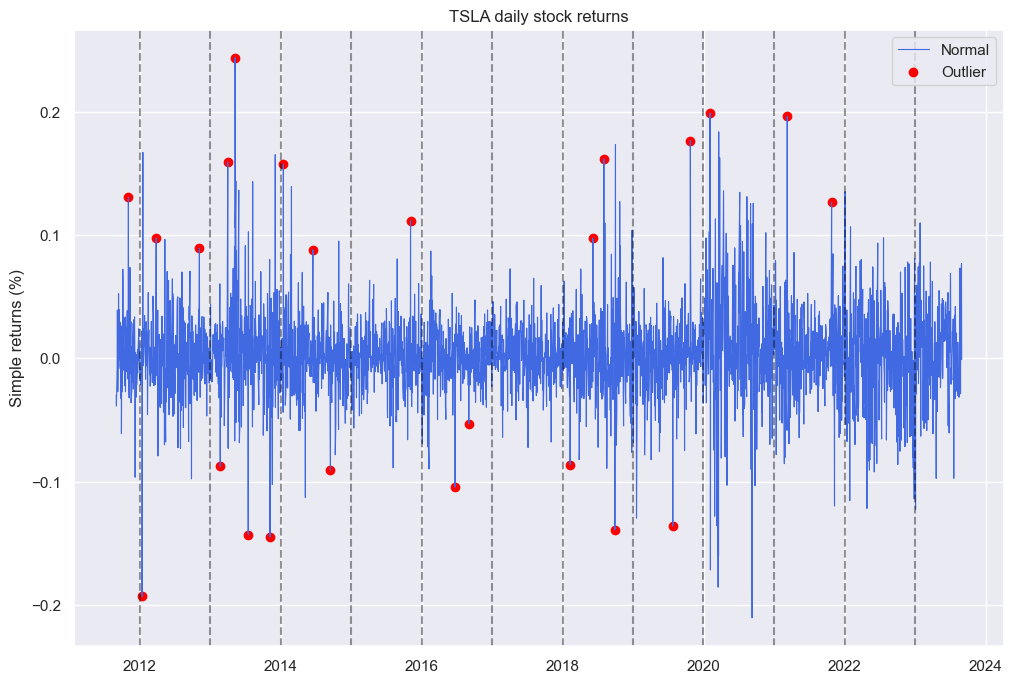

In [9]:
window_length = 22

## Calculating the one month rolling mean and standard deviation

df1_rolling_stats = df1['simple_returns'].rolling(window
                                                  =window_length).agg(['mean',
                                                                       'std'], axis='rows')

df1_rolling_stats.tail()

## Joining the newly created data to the original data

df1_all = df1.join(df1_rolling_stats)

df1_all.tail()

## Defining a function to catch outliers

def catch_outliers(row, n_sigmas=3):
    x = row['simple_returns']
    μ = row['mean']
    σ = row['std']
    
    if (x > μ + 3 * σ) | (x < μ - 3 * σ):
        return 1
    else:
        return 0

## Catch the outliers

df1_all['outlier'] = df1_all.apply(catch_outliers, axis='columns')

df1_all.head()

## Extract their values

outliers = df1_all.loc[df1_all['outlier'] == 1, ['simple_returns']]

outliers.tail()

outliers.shape

df1_all.shape

## Plotting the results together

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df1_all.index, df1_all['simple_returns'], color='royalblue', 
        linewidth=0.8, label="Normal")
ax.scatter(outliers.index, outliers['simple_returns'], color='red',
           label="Outlier")
ax.set(title=f"{ticker1} daily stock returns", 
          ylabel="Simple returns (%)")

for eachyear in range(start1.year,end1.year):
    ax.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

ax.legend(loc="best")

### Stylized facts of asset returns

[Cont (2001)](#cont2001) does a detailed review of the empirical features of asset prices in financial markets. He presents common statistical properties (***stylized facts***) that financial asset returns share across markets, instruments and time periods.

We should be cognizant of them when we develop models to explain and forecast asset prices. 
We now work with 40 years of S&P daily data to examine some of their characteristics.

In [10]:
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

end2 = datetime.date(2023, 9, 15)
start2 = datetime.date(1980, 1, 2)
ticker2 = "^GSPC"

df = yf.download(ticker2, start=start2, end=end2, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker2} data")

df2 = df.copy()

#############################################################################
###################### IGNORE THIS CELL #####################################
#############################################################################

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df2.to_csv("GLENMARK.NS.csv")
# df2 = pd.read_csv("GLENMARK.NS", index_col=0, parse_dates=True)
# df2 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

print(df2.head())
print(df2.tail())

df2.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df2.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df2.tail())

df2['log_returns'] = np.log(df2['adj_close'] / df2['adj_close'].shift(1))

Downloaded 11019 rows and 6 columns of ^GSPC data
            Open        High         Low       Close   Adj Close    Volume
Date                                                                      
1980-01-02   0.0  108.430000  105.290001  105.760002  105.760002  40610000
1980-01-03   0.0  106.080002  103.260002  105.220001  105.220001  50480000
1980-01-04   0.0  107.080002  105.089996  106.519997  106.519997  39130000
1980-01-07   0.0  107.800003  105.800003  106.809998  106.809998  44500000
1980-01-08   0.0  109.290001  106.290001  108.949997  108.949997  53390000
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-09-08  4451.299805  4473.529785  4448.379883  4457.490234  4457.490234   
2023-09-11  4480.979980  4490.770020  4467.890137  4487.459961  4487.459961   
2023-09-12  4473.270020  4487.109863  4456.830078  4461.899902  4461.899902   
2023-09-13  4462.649902  4479.

Text(0.5, 1.0, 'Q-Q plot')

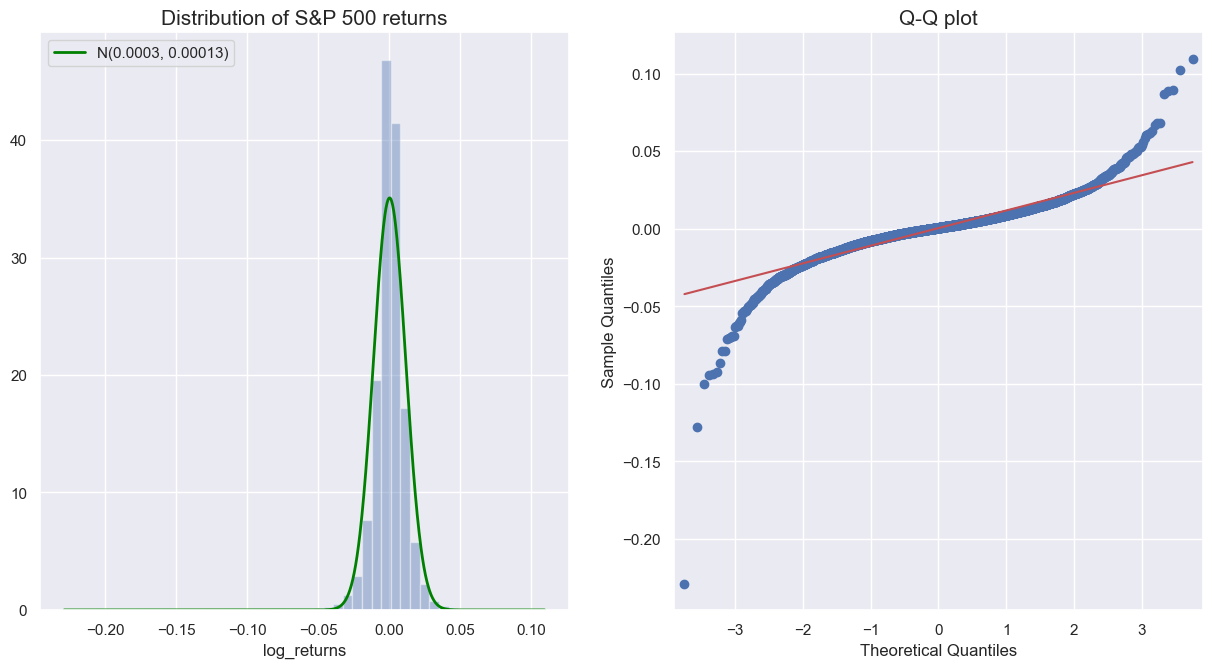

In [11]:
df2.dropna(axis='rows', how='any', inplace=True)

## Generating a normal distribution curve with mean, variance, and range obtained from S&P 500 returns data

log_returns_range = np.linspace(min(df2['log_returns']), max(df2['log_returns']), num=1000)
μ = df2['log_returns'].mean()
σ = df2['log_returns'].std()
norm_pdf = scs.norm.pdf(log_returns_range, loc=μ, scale=σ)

M = 1
N = 2

fig, ax = plt.subplots(M, N, figsize=(15, 7.5))

## histogram

sns.distplot(df2['log_returns'], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[0].plot(log_returns_range, norm_pdf, color='green', 
           linewidth=2, label=f"N({μ:.4f}, {σ**2:.5f})")
ax[0].legend(loc="best")

## Q-Q plot

qq_plot = sm.qqplot(df2['log_returns'], line='s', ax=ax[1])
## 's' is for standardized line to compare the plot with a normal distribution
ax[1].set_title("Q-Q plot", fontsize=15)

#### 1. Non-normal distribution of returns

A standard assumption in finance models (like the CAPM, the Black-Scholes option pricing model) is that returns are normally distributed.

Numerous studies have however shown empirically that this is not quite true.
Specifically,
- *Left skewed* : Gains and loss distributions are not symmetrical. 
    - We see longer left tails compared to the right tails
    - The large negative returns are higher in magnitude compared to the large positive returns. 
 
- *Excess kurtosis* : The distribution is fat at the tails and higher than normal peaks
    - Large (and small) returns occur more frequently than the distributional assumption of normality expects.

Points to note: *Distribution of S&P 500 returns*
- There is a visible difference in the shape of the returns histogram and the Gaussian (normal) distribution curve.
- The peak is higher in the histogram than the normal curve.
- The left tail of the distribution is longer.

Points to note: *Q-Q plot*

- Q-Q plots are used to compare empirical data to theoretical distributions. They are helpful in finding deviations at the tails.
- Here, we compare the distribution of the observed returns to a normal distribution.
- If we find that the dots are more or less on the red line, then it means that the data (in this case returns) is normally distributed.
- There is drift at both ends of the tails. This means that we have fatter tails violating the normality assumption.
- The size of the drift is higher on the left side of the plot than on the right side. This means that we observe large drops in returns but not equally large growths in returns.


In [12]:
## Running the Jarque-Bera test to check for normality of the sample data
## If the test statistic is very large and the p-value is less than 5%, we infer that the data is not
## normally distributed.

## For more details, check https://en.wikipedia.org/wiki/Jarque-Bera_test

from statsmodels.stats.stattools import jarque_bera
jb_test_stat, pvalue, _, _ = jarque_bera(df2['log_returns'])

## Printing the summmary statistics of the S&P 500 returns data

print('------------------- Summary Statistics --------------------')
print(f'Range of dates: {min(df2.index.date)} to {max(df2.index.date)}')
print(f'Number of observations: {df2.shape[0]}')
print(f"Mean: {df2['log_returns'].mean():.4f}")
print(f"Median: {df2['log_returns'].median():.4f}")
print(f"Min: {df2['log_returns'].min():.4f}")
print(f"Max: {df2['log_returns'].max():.4f}")
print(f"Standard Deviation: {df2['log_returns'].std():.4f}")
print(f"Skewness: {df2['log_returns'].skew():.4f}")
print(f"Kurtosis: {df2['log_returns'].kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")
print('-----------------------------------------------------------')

------------------- Summary Statistics --------------------
Range of dates: 1980-01-03 to 2023-09-14
Number of observations: 11018
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0114
Skewness: -1.0944
Kurtosis: 24.3939
Jarque-Bera statistic: 275122.38 with p-value: 0.00
-----------------------------------------------------------


Points to note:
- The mean is less than the median. Seen in negatively skewed distributions.
- Confirmed by the coefficient of skewness (which is negative).
- Excess kurtosis seen (anything above 0 is deemed as excess kurtosis. Normal distribution has a kurtosis of 0 when measured using the `pandas kurtosis` method) .
- The p-value of the Jarque-Bera test shows non-normality of the data.

#### 2. Volatility Clustering

> *When it rains, it pours*.

We observe from historical data that the volatility of the returns appears to change over time. Relatively tranquil periods in the market persist for a while. Similarly market turbulence like in 2008 and 2009 also cluster together.

In [13]:
# Simulating normally distributed returns for TSLA and S&P 500
sample1 = pd.DataFrame(np.random.normal(loc=df1['log_returns'].mean(), 
                                     scale=df1['log_returns'].std(), 
                                     size=df1['log_returns'].shape[0]), 
                    index = df1.index)

sample2 = pd.Series(np.random.normal(loc=df2['log_returns'].mean(), 
                                     scale=df2['log_returns'].std(), 
                                     size=df2['log_returns'].shape[0]), 
                    index = df2.index)


Text(0.5, 1.0, 'Simulated returns')

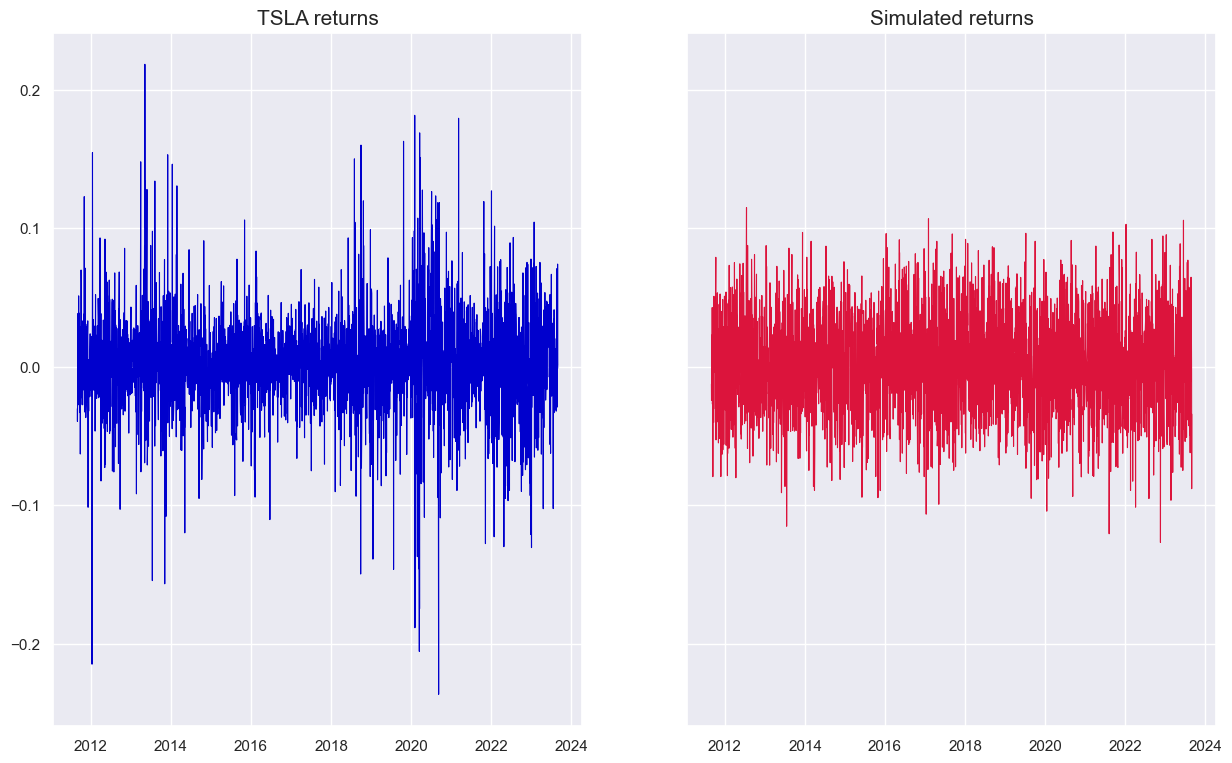

In [14]:
## Plotting the daily returns of TSLA and simulated data with same mean/sd side by side 

x = df1.index
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharey=True)
ax1.plot(x, df1['log_returns'], linewidth=0.8, color='mediumblue')
ax1.set_title("TSLA returns", fontsize=15)
ax2.plot(sample1, linewidth=0.8, color='crimson')
ax2.set_title("Simulated returns", fontsize=15)

Text(0.5, 1.0, 'Simulated returns')

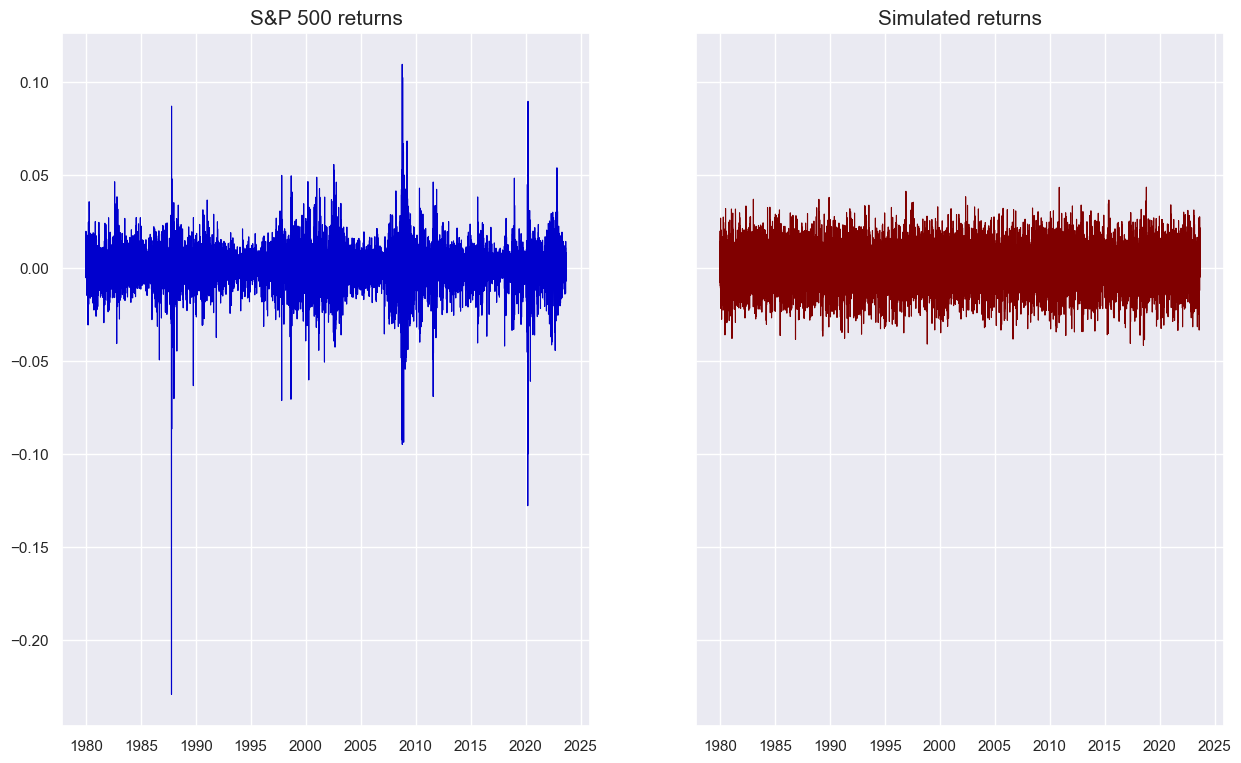

In [15]:
## Plotting the daily returns of S&P 500 and simulated data with same mean/sd side by side 

x = df2.index
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharey=True)
ax1.plot(x, df2['log_returns'], linewidth=0.8, color='mediumblue')
ax1.set_title("S&P 500 returns", fontsize=15)
ax2.plot(x, sample2, linewidth=0.8, color='maroon')
ax2.set_title("Simulated returns", fontsize=15)

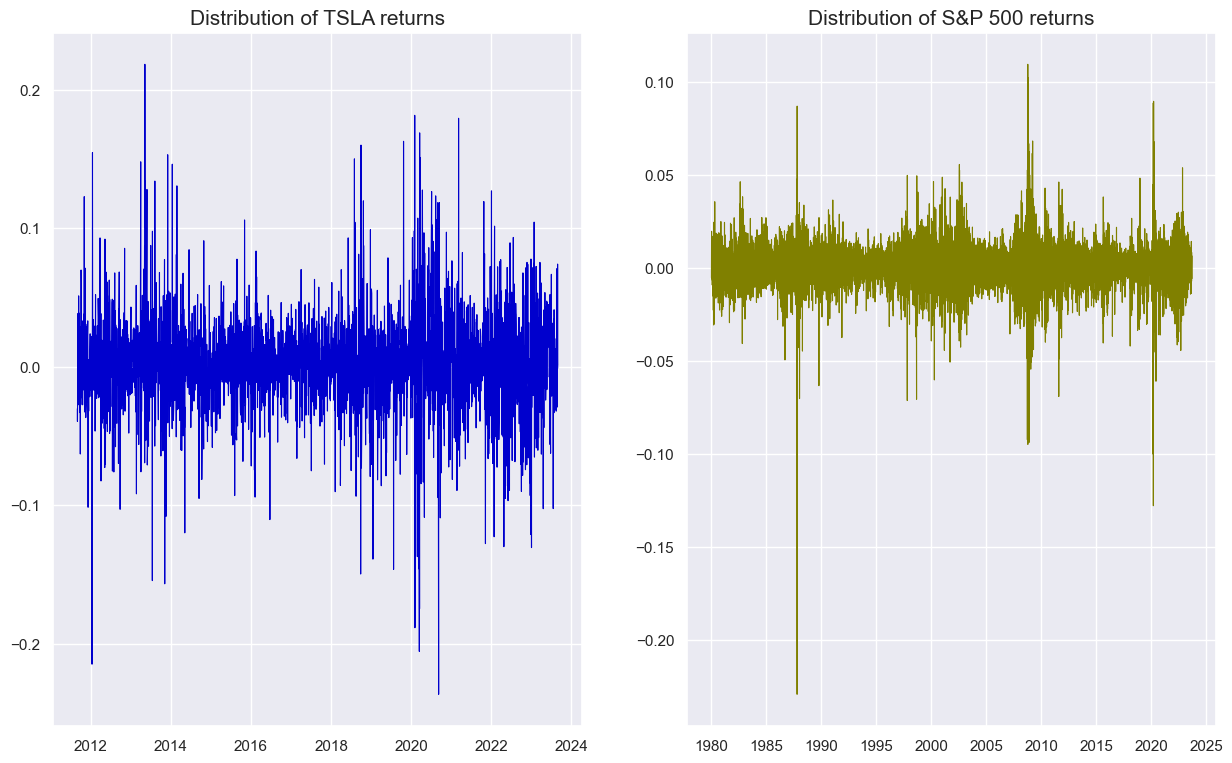

In [16]:
## Plotting the daily returns of TSLA and S&P 500 side by side 

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

ax[0].set_title("Distribution of TSLA returns", fontsize=15)
ax[0].plot(df1['log_returns'], linewidth=0.8, color='mediumblue')

ax[1].set_title("Distribution of S&P 500 returns", fontsize=15)
ax[1].plot(df2['log_returns'], linewidth=0.8, color='olive')

#### 3. Absence of autocorrelations

Autocorrelation measures the degree of similarity between a time series process and a delayed copy of itself. We measure it at different lags to unearth any patterns that repeat consistently.

Studies have shown that there is little autocorrelation observed in asset returns except for short time scales (of the order of 15 to 20 minutes).


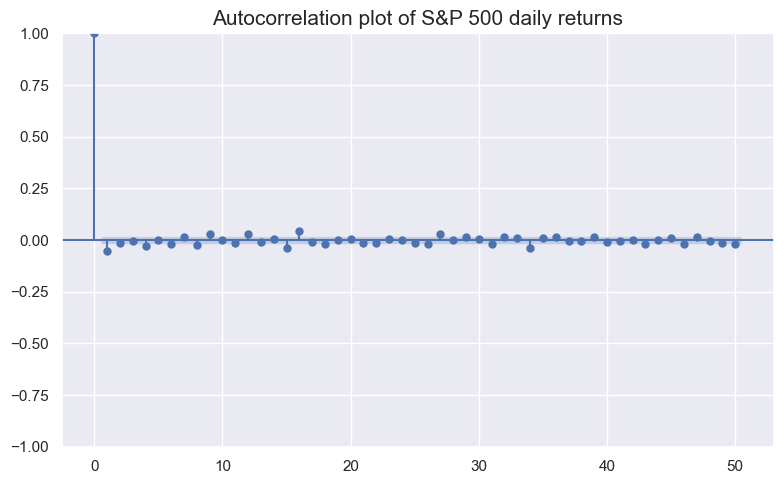

In [17]:
n_lags = 50
significance_level = 0.05
M = 8
N = 5

fig, ax = plt.subplots(figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'], lags=n_lags, 
                                 alpha=significance_level, ax=ax)
ax.set_title("Autocorrelation plot of S&P 500 daily returns", fontsize=15)
plt.tight_layout()
plt.show()

Points to note:
- We do not look at autocorrelation at lag 0.
- A few values that lie outside the blue confidence interval are statistically significant
- Visually, it appears that there is very little autocorrelation in the returns


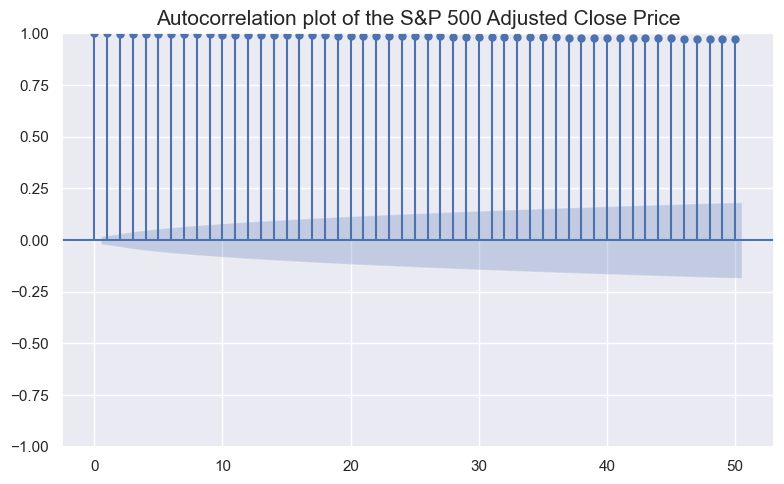

In [18]:
M = 8
N = 5

fig, ax = plt.subplots(figsize=(M, N))
smt.graphics.plot_acf(df2['adj_close'], lags=n_lags, 
                                 alpha=significance_level, ax=ax)
ax.set_title("Autocorrelation plot of the S&P 500 Adjusted Close Price", fontsize=15)
plt.tight_layout()
plt.show()

#### 4. Slow decay of autocorrelations in absolute and squared returns

We follow the same procedure as above but this time we run it on absolute returns and squared returns. We can then plot the autocorrelation function (ACF) at different lags.

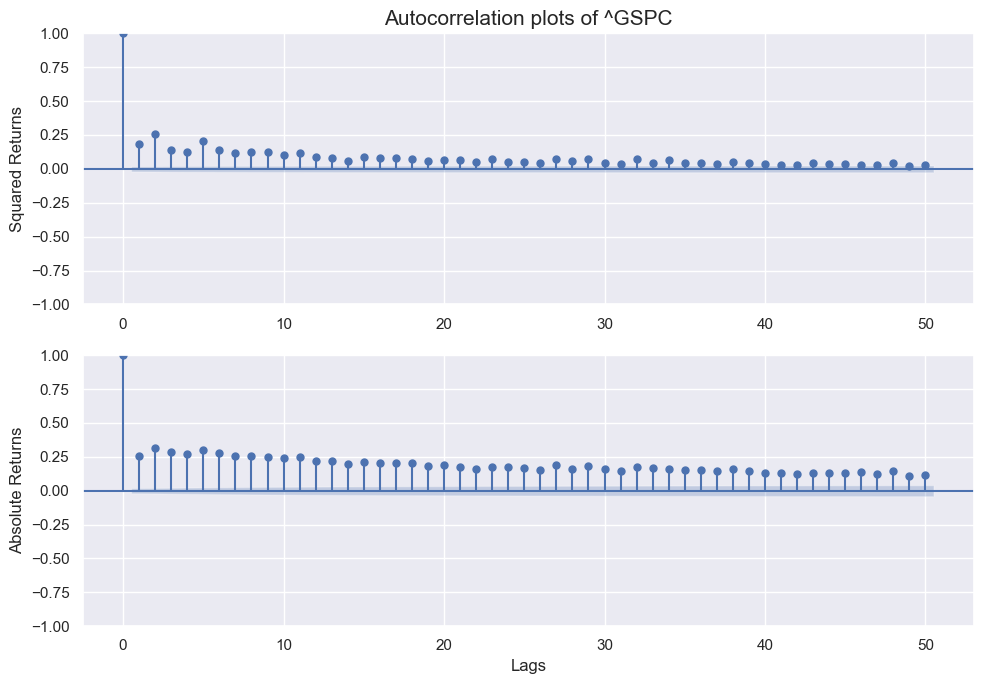

In [19]:
M, N = 10, 7
fig, ax = plt.subplots(2, 1, figsize=(M, N))
smt.graphics.plot_acf(df2['log_returns'] ** 2, lags=n_lags, 
                      alpha=significance_level, ax=ax[0])
ax[0].set_title(f"Autocorrelation plots of {ticker2}", fontsize=15)
ax[0].set(ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df2['log_returns']), lags=n_lags, 
                      alpha=significance_level, ax=ax[1])
ax[1].set(title="", xlabel='Lags', ylabel="Absolute Returns")

plt.tight_layout()
plt.show()

Points to note:
- There is is a slow and uneven decay of the ACF plot.
- The ACF of the squared returns decrease faster than that of the absolute returns.
- There is significant autocorrelation as seen in the literature.

#### 5. Leverage effect

There is a negative correlation between the volatility (most measures) of an asset and its returns. i.e. When prices go up, there is less volatility in the asset returns and vice-versa.

We verify it using two different methods. 

- In the first one, we measure volatility as the standard deviation of the asset returns. 
- In the second one, we will use the VIX index (often called the *fear index* of Wall Street), a popular market metric that tracks expectations of volatility.

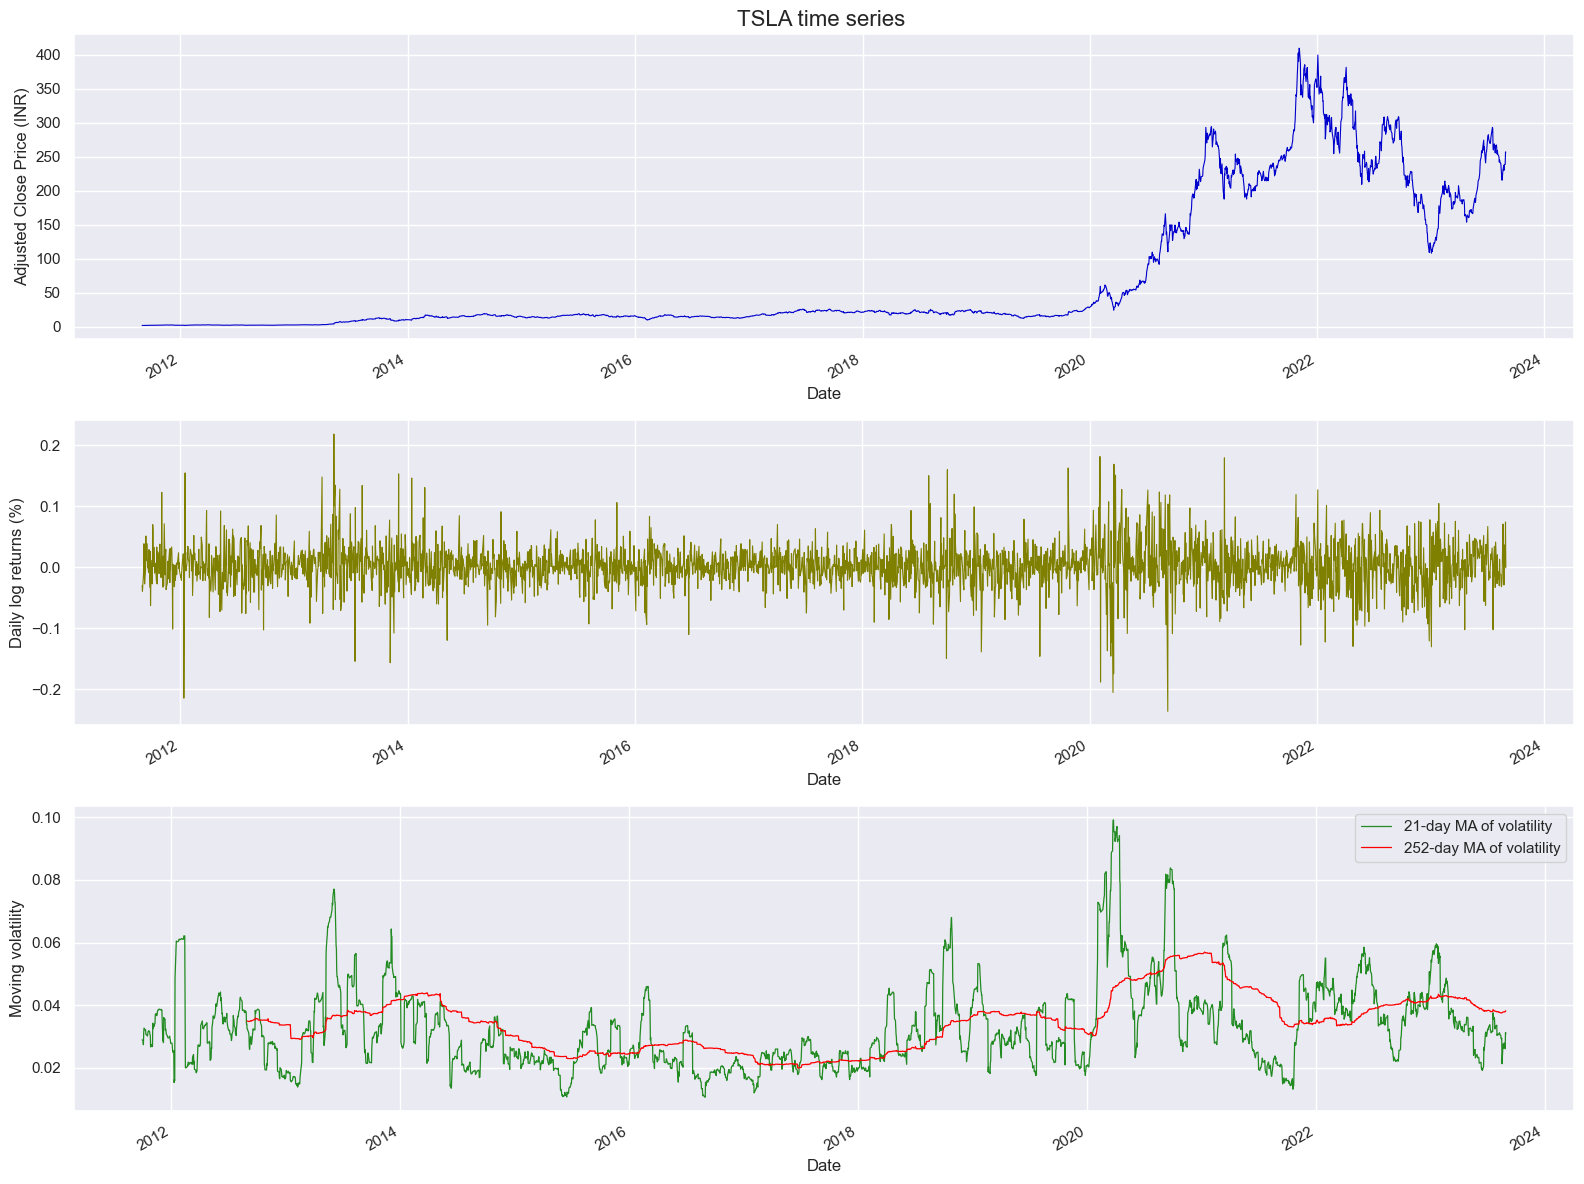

In [20]:
df1['ma_std_252'] = df1['log_returns'].rolling(window=252).std()
df1['ma_std_21'] = df1['log_returns'].rolling(window=21).std()

## Method I

M, N = 16, 12
fig, ax = plt.subplots(3, 1, figsize=(M, N))

df1['adj_close'].plot(ax=ax[0], linewidth=0.8, color='mediumblue')
ax[0].set_title(f"{ticker1} time series ", fontsize=16)
ax[0].set(ylabel="Adjusted Close Price (INR)")


df1['log_returns'].plot(ax=ax[1], linewidth=0.8, color='olive')
ax[1].set(ylabel="Daily log returns (%)")

df1['ma_std_21'].plot(ax=ax[2], color='forestgreen', linewidth = 0.9, label="21-day MA of volatility")
df1['ma_std_252'].plot(ax=ax[2], color='red', linewidth = 0.9, label="252-day MA of volatility")
ax[2].set(xlabel="Date", ylabel="Moving volatility")
ax[2].legend()

plt.tight_layout()

In [21]:
## Method II

start3 = start2
end3 = end2
ticker3 = "^VIX"

df = yf.download([ticker2, ticker3], start=start3, end=end3, progress=True)

[*********************100%***********************]  2 of 2 completed


In [22]:
df3 = df.copy()

df3 = df3[['Adj Close']]

df3.columns

df3.columns = df3.columns.droplevel(0)

df3.rename(columns={"^GSPC": "sp500", "^VIX": "vix"}, inplace=True)

In [24]:
df3["log_returns"] = np.log(df3['sp500'] / df3['sp500'].shift(1))
df3["vol_returns"] = np.log(df3['vix'] / df3['vix'].shift(1))

df3.dropna(how="any", axis="rows", inplace=True)

corr_coeff = df3['log_returns'].corr(df3['vol_returns'])

corr_coeff

-0.708922243089

[Text(0.5, 1.0, 'S&P 500 vs. VIX (ρ = -0.709)'),
 Text(0.5, 0, 'S&P 500 log returns'),
 Text(0, 0.5, 'VIX log returns')]

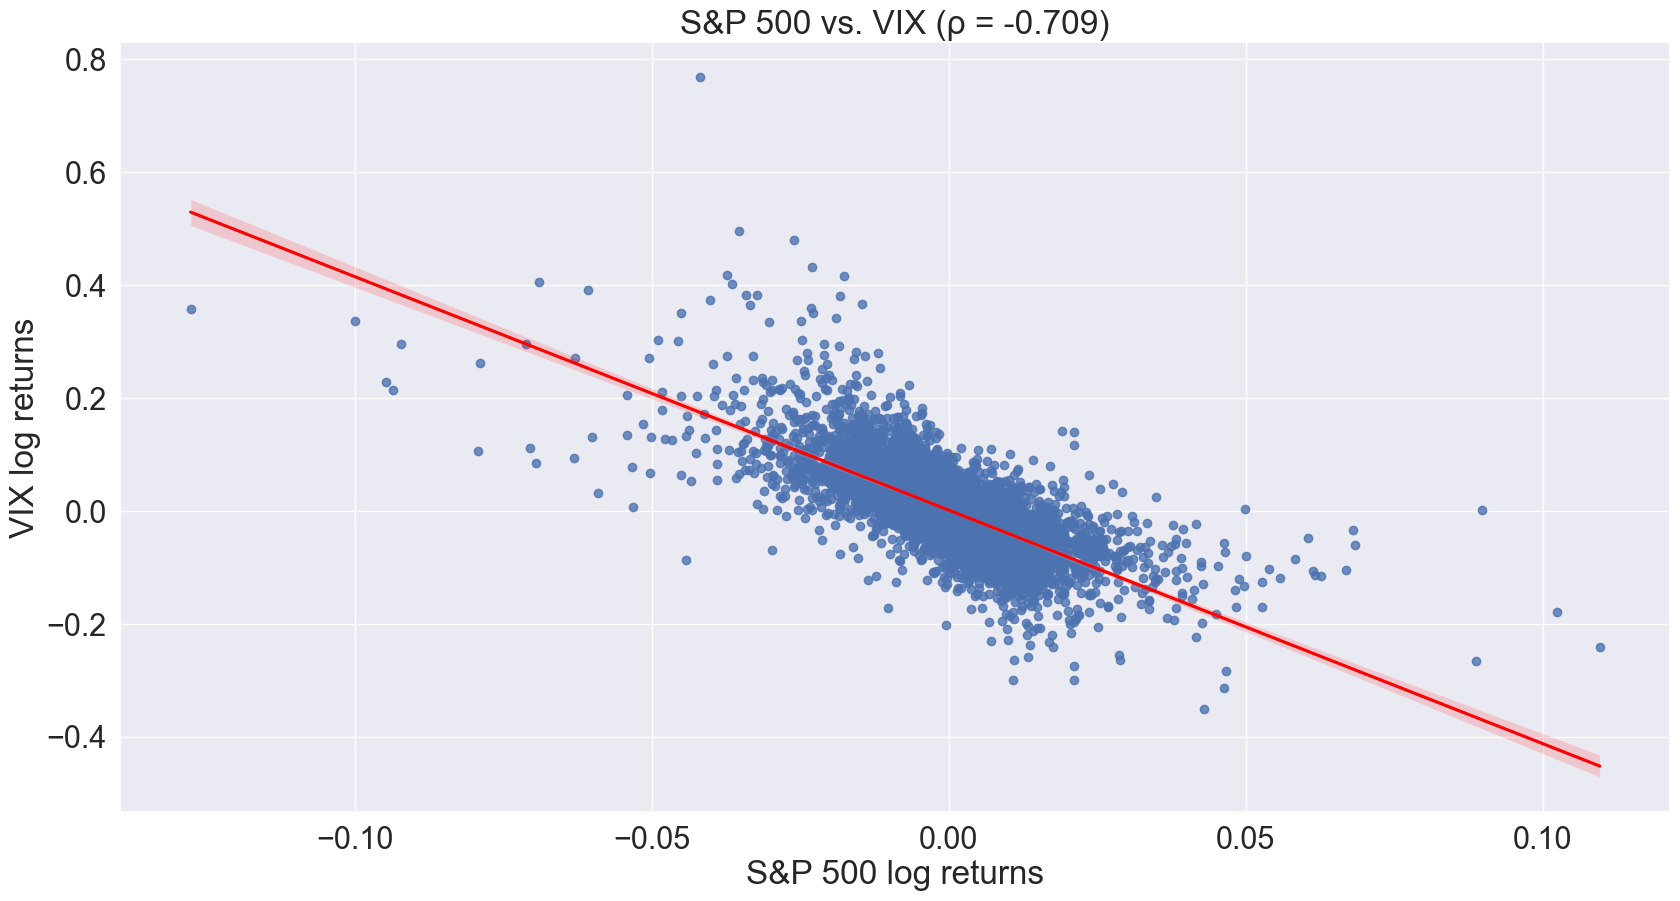

In [27]:
## Plotting the regression plot to observe the correlation
plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
ax = sns.regplot(x='log_returns', y='vol_returns', data=df3, 
                 line_kws={'color':'red'})
ax.set(title=f"S&P 500 vs. VIX (ρ = {corr_coeff:.3f})", 
       xlabel="S&P 500 log returns", ylabel="VIX log returns")